# 1. Import Packages and Spark Database

In [71]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.model_selection import train_test_split, GridSearchCV

#Load dataset using Pandas
data=pd.read_csv('winequality-red.csv')
data.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


# 2. Data Clean-up

In [72]:
# Remove rows with missing values
data.dropna(inplace=True)

In [73]:
# Check for null values again after cleanup
print("Null values after cleanup:")
print(data.isnull().sum())

Null values after cleanup:
fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64


In [74]:
#show number of rolls and detail of dataframe
data.info

<bound method DataFrame.info of       fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0               7.4             0.700         0.00             1.9      0.076   
1               7.8             0.880         0.00             2.6      0.098   
2               7.8             0.760         0.04             2.3      0.092   
3              11.2             0.280         0.56             1.9      0.075   
4               7.4             0.700         0.00             1.9      0.076   
...             ...               ...          ...             ...        ...   
1594            6.2             0.600         0.08             2.0      0.090   
1595            5.9             0.550         0.10             2.2      0.062   
1596            6.3             0.510         0.13             2.3      0.076   
1597            5.9             0.645         0.12             2.0      0.075   
1598            6.0             0.310         0.47             3.6      0.067

## 2.1 Check bias and classifications

In [75]:
# Assuming 'data' is your DataFrame
quality_counts = data['quality'].value_counts().sort_index(ascending=False)
print(quality_counts)

quality
8     18
7    199
6    638
5    681
4     53
3     10
Name: count, dtype: int64


In [76]:
# Create clasiification Good (6 and above) and Bad (6 and below)
bins = [0, 5.9, 10]  # 5.9 to include 6 in the "6 and above" category
labels = ['below 6', '6 and above']

# Bin the 'quality' column
quality_categories = pd.cut(data['quality'], bins=bins, labels=labels, include_lowest=True)

# Count occurrences of each category
quality_counts = quality_categories.value_counts()

# Calculate percentages
quality_percentages = ((quality_counts / quality_counts.sum())* 100).round(2)

quality_percentages_df = pd.DataFrame(quality_percentages)
quality_percentages_df

,count
quality,
6 and above,53.47
below 6,46.53


## Check correlation of all features

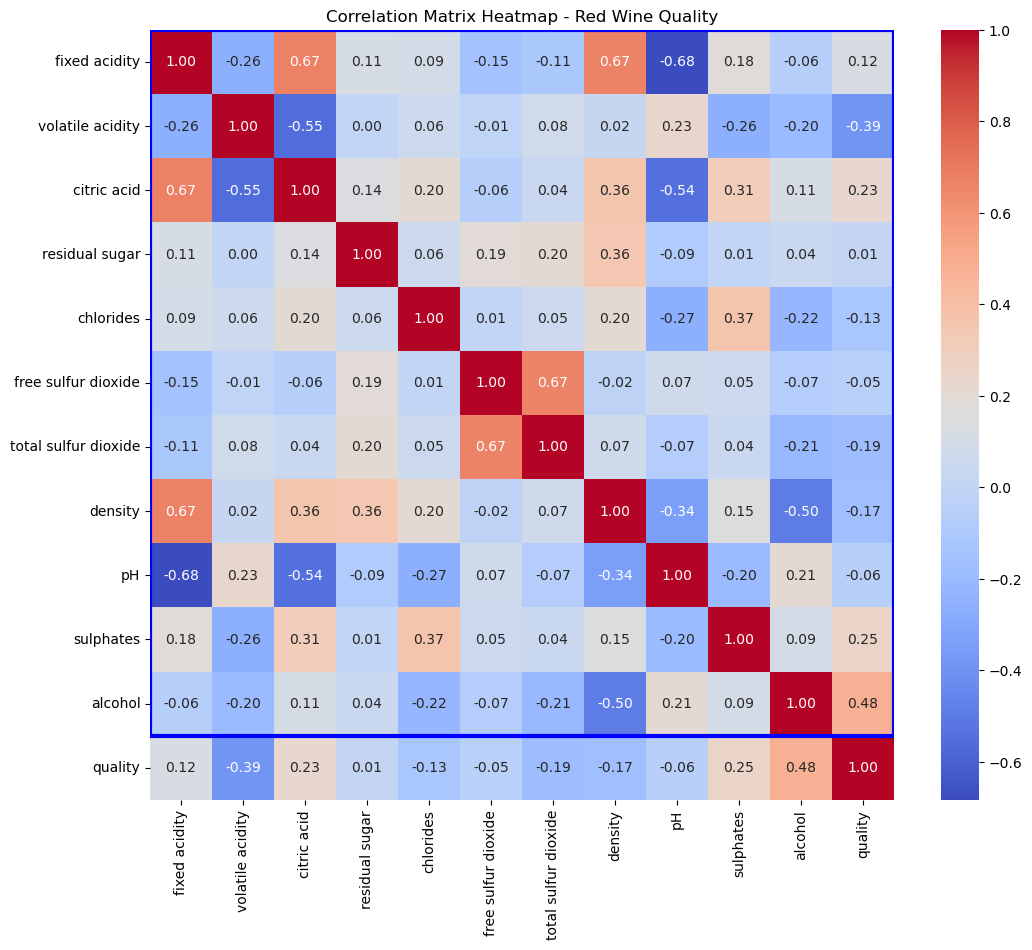

In [77]:
# Compute the correlation matrix 
# Calculate correlation matrix
correlation_matrix = data.corr()

# Set up the matplotlib figure
plt.figure(figsize=(12, 10))

# Draw the heatmap with the mask and correct aspect ratio
heatmap = sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")

# Add title
plt.title('Correlation Matrix Heatmap - Red Wine Quality')

# Highlight correlations with 'Potability'
highlight = correlation_matrix['quality'].sort_values(ascending=False)
highlight = highlight.drop('quality')  # Remove self-correlation
highlight_cols = highlight.index.tolist()
heatmap.add_patch(plt.Rectangle((0, 0), len(correlation_matrix), len(highlight_cols), fill=False, edgecolor='blue', lw=3))

# Show plot
plt.show()

# 3. Normalisation and Standardization 

In [78]:
# Separate features and target variable
X = data.drop('quality', axis=1)
y = data['quality']

In [79]:
# Normalize or scale the features if necessary
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [80]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=50)


# 4. Machine Learning Model Attempts
## 4.1 Random Forest Model

In [81]:
# Initialize and fit the Random Forest model
rf_model = RandomForestClassifier(random_state=50)
rf_model.fit(X_train, y_train)


RandomForestClassifier(random_state=50)

In [82]:
# Make predictions on the test set
y_pred = rf_model.predict(X_test)

# Get feature importances
feature_importances = rf_model.feature_importances_

# Create a DataFrame to display feature importances
importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)
importance_df

,Feature,Importance
10,alcohol,0.150609
9,sulphates,0.115033
1,volatile acidity,0.102129
6,total sulfur dioxide,0.101270
7,density,0.091951
0,fixed acidity,0.080192
4,chlorides,0.079843
8,pH,0.076647
2,citric acid,0.070201
3,residual sugar,0.067891


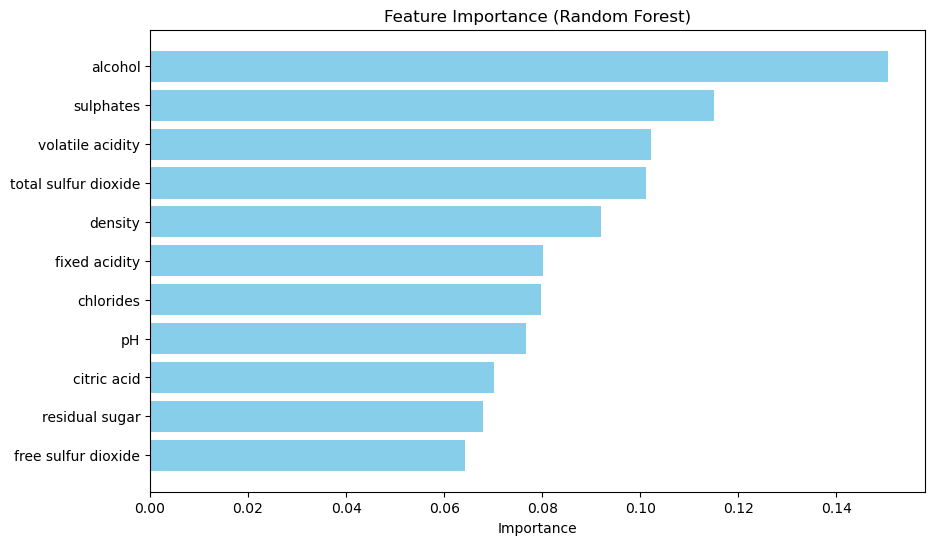

In [83]:
# Plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.title('Feature Importance (Random Forest)')
plt.gca().invert_yaxis()  # Invert y-axis to display features with the most important at the top
plt.show()

In [84]:
# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

Accuracy: 0.72


## 4.1.1 Optimization : Test_size 0.2

In [85]:
X = data.drop('quality', axis=1)
y = data['quality']
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=50)
rf_model = RandomForestClassifier(random_state=50)
rf_model.fit(X_train, y_train)

RandomForestClassifier(random_state=50)

In [86]:
y_pred = rf_model.predict(X_test)
# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

Accuracy: 0.740625


## 4.2 Linear Regression 
## 4.2.1 Optimization: Utilize categorization Good (6 and above) and Bad (below 6)

In [87]:
X = data.drop(['quality'], axis=1)
y = data['quality']

In [88]:
# Convert quality into categories (assuming good: 6-8, bad: below 6)
threshold = 6
y_binary = (y >= threshold).astype(int)  # 1 for good, 0 for bad

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_binary, test_size=0.2, random_state=42)

# Feature scaling (standardization)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train the Logistic Regression model
model = LogisticRegression()
model.fit(X_train_scaled, y_train)

# Make predictions on test set
y_pred = model.predict(X_test_scaled)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)

# Print the accuracy score
print(f"Accuracy: {accuracy:.4f}")

# Print classification report
print(classification_report(y_test, y_pred))

Accuracy: 0.7406
              precision    recall  f1-score   support

           0       0.69      0.74      0.72       141
           1       0.79      0.74      0.76       179

    accuracy                           0.74       320
   macro avg       0.74      0.74      0.74       320
weighted avg       0.74      0.74      0.74       320



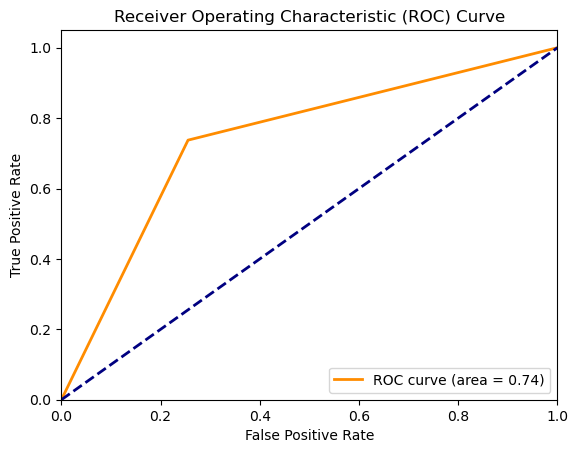

In [89]:
#Plot ROC curve
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

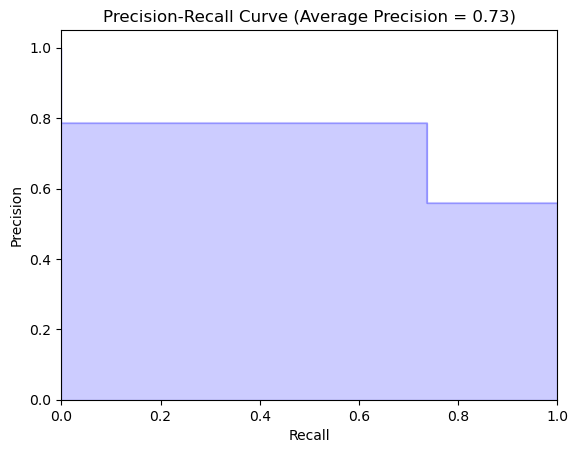

In [90]:
# Calculate precision and recall
precision, recall, _ = precision_recall_curve(y_test, y_pred)

# Calculate average precision score
average_precision = average_precision_score(y_test, y_pred)

# Plot Precision-Recall curve
plt.figure()
plt.step(recall, precision, color='b', alpha=0.2, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall Curve (Average Precision = {0:0.2f})'.format(average_precision))
plt.show()

## 4.3 Decision Tree
### 4.3.1 Optiomization: with categorization (Remove less important feature)

In [91]:
X = data.drop(['free sulfur dioxide','quality'], axis=1)
y = data['quality']

# Convert quality into categories (assuming good: 6-8, bad: below 6)
threshold = 6
y_binary = (y >= threshold).astype(int)  # 1 for good, 0 for bad

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_binary, test_size=0.2, random_state=42)

# Initialize Decision Tree classifier
model = DecisionTreeClassifier(random_state=42)

# Train the model
model.fit(X_train, y_train)

# Make predictions on test set
y_pred = model.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)

# Print the accuracy score
print(f"Accuracy: {accuracy:.4f}")
print(classification_report(y_test, y_pred))

Accuracy: 0.7531
              precision    recall  f1-score   support

           0       0.71      0.74      0.73       141
           1       0.79      0.76      0.77       179

    accuracy                           0.75       320
   macro avg       0.75      0.75      0.75       320
weighted avg       0.75      0.75      0.75       320



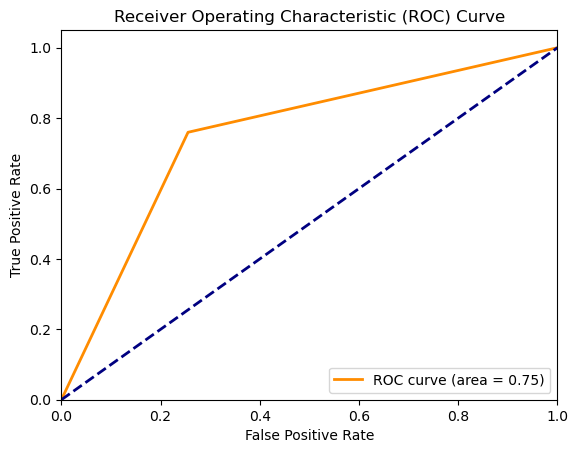

In [92]:
#Plot ROC curve
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

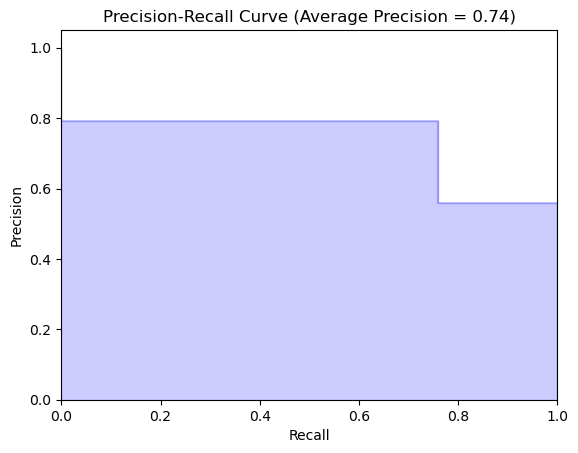

In [93]:
# Calculate precision and recall
precision, recall, _ = precision_recall_curve(y_test, y_pred)

# Calculate average precision score
average_precision = average_precision_score(y_test, y_pred)

# Plot Precision-Recall curve
plt.figure()
plt.step(recall, precision, color='b', alpha=0.2, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall Curve (Average Precision = {0:0.2f})'.format(average_precision))
plt.show()

### 4.3.2 Optimization: Hyperparameter Tuning

In [94]:
# Hyperparameter Tuning for Decision Tree
param_grid = {
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}
grid_search = GridSearchCV(estimator=DecisionTreeClassifier(random_state=42, class_weight='balanced'), param_grid=param_grid, cv=5, scoring='f1')
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=DecisionTreeClassifier(class_weight='balanced',
                                              random_state=42),
             param_grid={'max_depth': [None, 10, 20],
                         'min_samples_leaf': [1, 2],
                         'min_samples_split': [2, 5]},
             scoring='f1')

In [95]:
# Best parameters and re-evaluation
print(f"Best Parameters: {grid_search.best_params_}")
best_tree_clf = grid_search.best_estimator_
y_pred_best_tree = best_tree_clf.predict(X_test)
print("Optimized Decision Tree Classification Report:")
print(classification_report(y_test, y_pred_best_tree))

Best Parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2}
Optimized Decision Tree Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.73      0.71       141
           1       0.78      0.73      0.75       179

    accuracy                           0.73       320
   macro avg       0.73      0.73      0.73       320
weighted avg       0.73      0.73      0.73       320



## Is this 4.1.2 Optimization?

In [96]:
# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'class_weight': ['balanced']  # For handling class imbalance
}

In [97]:
# Initialize the model
rf = RandomForestClassifier(random_state=42)

In [98]:
# Initialize Grid Search
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring='f1', n_jobs=-1)


In [99]:
# Fit Grid Search to the data
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'class_weight': ['balanced'],
                         'max_depth': [None, 10, 20],
                         'min_samples_leaf': [1, 2],
                         'min_samples_split': [2, 5],
                         'n_estimators': [100, 200]},
             scoring='f1')

In [100]:
# Best parameters and score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print(f"Best Parameters: {best_params}")
print(f"Best Score: {best_score}")

Best Parameters: {'class_weight': 'balanced', 'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}
Best Score: 0.8285139629220974


## Up to here

### 4.3.2 Optimisation: Narrow classification good (7 and above) and Bad (less than 7)

In [101]:
X = data.drop(['free sulfur dioxide','quality'], axis=1)
y = data['quality']

# Convert quality into categories (assuming good: 7-10, bad: below 7)
threshold = 7
y_binary = (y >= threshold).astype(int)  # 1 for good, 0 for bad

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_binary, test_size=0.2, random_state=42)

# Initialize Decision Tree classifier
model = DecisionTreeClassifier(random_state=42)

# Train the model
model.fit(X_train, y_train)

# Make predictions on test set
y_pred = model.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)

# Print the accuracy score
print(f"Accuracy: {accuracy:.4f}")

Accuracy: 0.8719


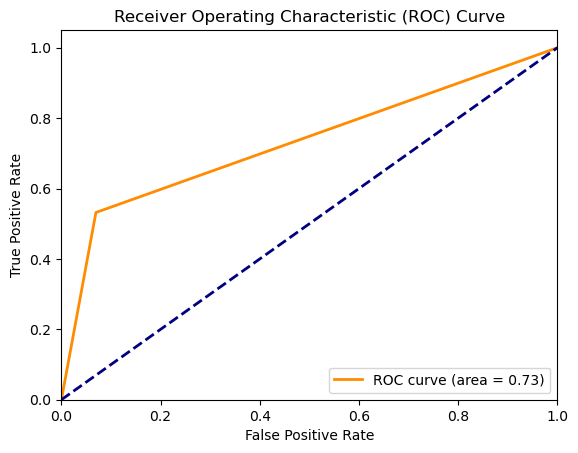

In [102]:
#Plot ROC curve
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

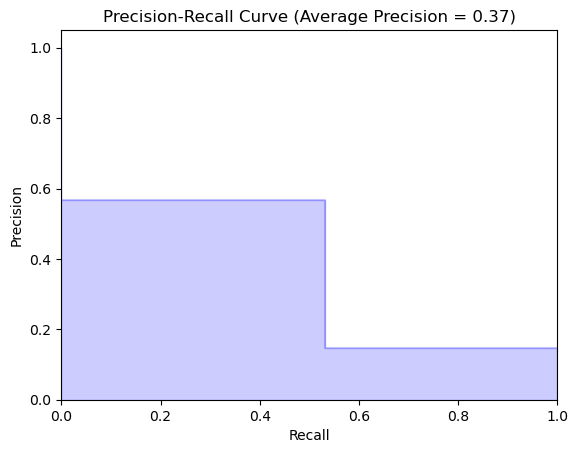

In [103]:
# Calculate precision and recall
precision, recall, _ = precision_recall_curve(y_test, y_pred)

# Calculate average precision score
average_precision = average_precision_score(y_test, y_pred)

# Plot Precision-Recall curve
plt.figure()
plt.step(recall, precision, color='b', alpha=0.2, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall Curve (Average Precision = {0:0.2f})'.format(average_precision))
plt.show()

## 4.4 Tensorflow neural network model
#### Drop highly corelated columns pH, fixed acidity and citric acid, retain density as it has higher importance

In [104]:
nn_df = data.drop(['citric acid', 'fixed acidity', 'pH'], axis =1)
nn_df.head()

,volatile acidity,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,sulphates,alcohol,quality
0,0.70,1.9,0.076,11.0,34.0,0.9978,0.56,9.4,5
1,0.88,2.6,0.098,25.0,67.0,0.9968,0.68,9.8,5
2,0.76,2.3,0.092,15.0,54.0,0.9970,0.65,9.8,5
3,0.28,1.9,0.075,17.0,60.0,0.9980,0.58,9.8,6
4,0.70,1.9,0.076,11.0,34.0,0.9978,0.56,9.4,5


In [105]:
# Separate features and target variable
X = nn_df.drop('quality', axis=1)
y = nn_df['quality']
X

,volatile acidity,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,sulphates,alcohol
0,0.700,1.9,0.076,11.0,34.0,0.99780,0.56,9.4
1,0.880,2.6,0.098,25.0,67.0,0.99680,0.68,9.8
2,0.760,2.3,0.092,15.0,54.0,0.99700,0.65,9.8
3,0.280,1.9,0.075,17.0,60.0,0.99800,0.58,9.8
4,0.700,1.9,0.076,11.0,34.0,0.99780,0.56,9.4
...,...,...,...,...,...,...,...,...
1594,0.600,2.0,0.090,32.0,44.0,0.99490,0.58,10.5
1595,0.550,2.2,0.062,39.0,51.0,0.99512,0.76,11.2
1596,0.510,2.3,0.076,29.0,40.0,0.99574,0.75,11.0
1597,0.645,2.0,0.075,32.0,44.0,0.99547,0.71,10.2


In [106]:
y

0       5
1       5
2       5
3       6
4       5
       ..
1594    5
1595    6
1596    6
1597    5
1598    6
Name: quality, Length: 1599, dtype: int64

In [107]:
# Split the preprocessed data into a training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [108]:
import sklearn as skl

# Create a StandardScaler instances
scaler = skl.preprocessing.StandardScaler()

# Fit the StandardScaler
scaler.fit(X_train)

# Scale the data
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [109]:
X_train_scaled

array([[-0.23260309, -0.24631811, -0.1107459 , ...,  1.75695516,
        -1.3131938 , -1.15257747],
       [ 0.37802632, -0.24631811,  0.19329395, ...,  1.10531515,
        -0.97064635, -1.24703683],
       [ 0.32251456, -0.31717594,  0.05140868, ..., -1.02337554,
        -0.62809889,  1.01998773],
       ...,
       [ 0.48904985,  0.10797101, -0.23236184, ...,  0.37765048,
        -0.68519014, -0.8691994 ],
       [-1.84244427, -0.60060724, -0.69855628, ..., -1.18628555,
         0.79918216,  1.39782516],
       [-1.34283839, -0.60060724, -0.51613237, ..., -2.85882824,
        -0.68519014,  2.90917487]])

In [110]:
y_train

582     5
626     5
1030    7
620     5
490     6
       ..
1130    6
1294    6
860     5
1459    7
1126    6
Name: quality, Length: 1199, dtype: int64

In [111]:
# to_categorical returns a matrix of binary values (either ‘1’ or ‘0’). 
# It has number of rows equal to the length of the input vector and number of columns equal to the number of classes.
# Quality of wine is continuous value from 1 to 10 and not a binary decision

In [112]:
from keras.utils import to_categorical

y_train = to_categorical(y_train, 11)
# Original label of `5` is one-hot encoded as `0000010000`
y_test = to_categorical(y_test, 11)
y_train[0]

array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.])

In [113]:
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.callbacks import ModelCheckpoint

# Define the model - deep neural net, i.e., the number of input features and hidden nodes for each layer.
number_input_features = len(X_train_scaled[0])
print(number_input_features)
hidden_nodes_layer1 =  8
hidden_nodes_layer2 = 8
hidden_nodes_layer3 = 8

nn = tf.keras.models.Sequential()

# First hidden layer
nn.add(tf.keras.layers.Dense(units=hidden_nodes_layer1, input_dim=number_input_features, activation="sigmoid"))

# Second hidden layer
nn.add(tf.keras.layers.Dense(units=hidden_nodes_layer2, activation="relu"))

# Second hidden layer
nn.add(tf.keras.layers.Dense(units=hidden_nodes_layer3, activation="relu"))

# Output layer
nn.add(tf.keras.layers.Dense(units=11, activation="sigmoid"))

# Check the structure of the model
nn.summary()

8


C:\Users\Folio\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_8 (Dense)                      │ (None, 8)                   │              72 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 8)                   │              72 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 8)                   │              72 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 11)                  │              99 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 315 (1.23 KB)

 Trainable params: 315 (1.23 KB)

 Non-trainable params: 0 (0.00 B)

In [114]:
# Compile the model
nn.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [115]:
# Train the model
fit_model = nn.fit(X_train_scaled, y_train, epochs=200)

Epoch 1/200
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.1529 - loss: 0.6909
Epoch 2/200
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3512 - loss: 0.6410
Epoch 3/200
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3655 - loss: 0.5564
Epoch 4/200
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3717 - loss: 0.4368
Epoch 5/200
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4055 - loss: 0.3422
Epoch 6/200
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4587 - loss: 0.2822
Epoch 7/200
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5169 - loss: 0.2516
Epoch 8/200
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4995 - loss: 0.2240
Epoch 9/200
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4892 - loss: 0.2105
Epoch 10/200
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4644 - loss: 0.2016
Epoch 11/200
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4863 - loss: 0.1937
Epoch 12/200
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy:

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5827 - loss: 0.1521
Epoch 70/200
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5818 - loss: 0.1513
Epoch 71/200
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6046 - loss: 0.1495
Epoch 72/200
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5873 - loss: 0.1485
Epoch 73/200
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6080 - loss: 0.1532
Epoch 74/200
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5788 - loss: 0.1508
Epoch 75/200
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6050 - loss: 0.1495
Epoch 76/200
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5980 - loss: 0.1489
Epoch 77/200
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5928 - loss: 0.1547
Epoch 78/200
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6066 - loss: 0.1482
Epoch 79/200
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5733 - loss: 0.1533
Epoch 80/200
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6117 - loss: 0.1470
Epoch 138/200
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5956 - loss: 0.1516
Epoch 139/200
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6049 - loss: 0.1485
Epoch 140/200
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5895 - loss: 0.1495
Epoch 141/200
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6055 - loss: 0.1466
Epoch 142/200
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6148 - loss: 0.1506
Epoch 143/200
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6265 - loss: 0.1434
Epoch 144/200
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6129 - loss: 0.1477
Epoch 145/200
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6200 - loss: 0.1458
Epoch 146/200
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5977 - loss: 0.1512
Epoch 147/200
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6259 - loss: 0.1459
Epoch 148/200
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - ac

In [116]:
# Evaluate the model using the test data
model_loss, model_accuracy = nn.evaluate(X_test_scaled,y_test,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

13/13 - 0s - 21ms/step - accuracy: 0.6000 - loss: 0.1475
Loss: 0.14752021431922913, Accuracy: 0.6000000238418579


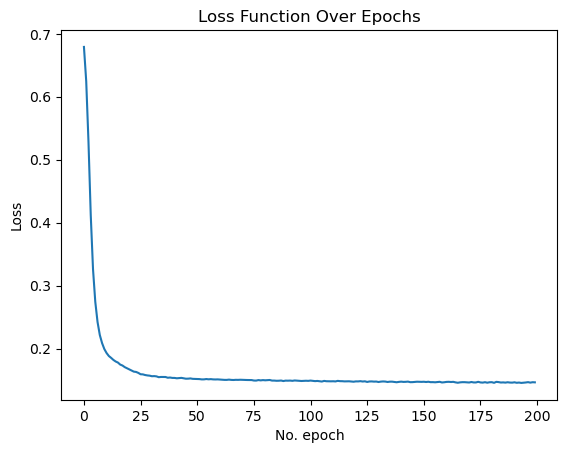

In [117]:
plt.plot(fit_model.history['loss'])
plt.title('Loss Function Over Epochs')
plt.ylabel('Loss')
plt.xlabel('No. epoch')
plt.show()

## 4.4.1 Optimization 1
#### Change loss function to mean squared error

In [118]:
# Compile the model
nn.compile(loss="mean_squared_error", optimizer="adam", metrics=["accuracy"])

In [119]:
# Train the model
fit_model = nn.fit(X_train_scaled, y_train, epochs=200)

Epoch 1/200
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5845 - loss: 0.0484
Epoch 2/200
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6264 - loss: 0.0463
Epoch 3/200
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6091 - loss: 0.0469
Epoch 4/200
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6312 - loss: 0.0463
Epoch 5/200
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6052 - loss: 0.0481
Epoch 6/200
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6310 - loss: 0.0459
Epoch 7/200
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6480 - loss: 0.0442
Epoch 8/200
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6060 - loss: 0.0479
Epoch 9/200
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6078 - loss: 0.0467
Epoch 10/200
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6230 - loss: 0.0460
Epoch 11/200
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6146 - loss: 0.0456
Epoch 12/200
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy:

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6385 - loss: 0.0446
Epoch 70/200
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6318 - loss: 0.0454
Epoch 71/200
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6337 - loss: 0.0456
Epoch 72/200
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6287 - loss: 0.0462
Epoch 73/200
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6414 - loss: 0.0453
Epoch 74/200
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6334 - loss: 0.0466
Epoch 75/200
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6343 - loss: 0.0449
Epoch 76/200
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6466 - loss: 0.0451
Epoch 77/200
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6516 - loss: 0.0452
Epoch 78/200
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6646 - loss: 0.0443
Epoch 79/200
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6283 - loss: 0.0457
Epoch 80/200
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6475 - loss: 0.0451
Epoch 138/200
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6505 - loss: 0.0441
Epoch 139/200
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6389 - loss: 0.0442
Epoch 140/200
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6456 - loss: 0.0457
Epoch 141/200
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6413 - loss: 0.0446
Epoch 142/200
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6394 - loss: 0.0455
Epoch 143/200
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6480 - loss: 0.0435
Epoch 144/200
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6410 - loss: 0.0458
Epoch 145/200
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6280 - loss: 0.0454
Epoch 146/200
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6398 - loss: 0.0455
Epoch 147/200
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6631 - loss: 0.0433
Epoch 148/200
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - ac

In [120]:
# Evaluate the model using the test data
model_mse, model_accuracy = nn.evaluate(X_test_scaled,y_test,verbose=2)
print(f"loss: {model_mse}, Accuracy: {model_accuracy}")

13/13 - 0s - 17ms/step - accuracy: 0.5800 - loss: 0.0486
mean_sq_error: 0.0485563687980175, Accuracy: 0.5799999833106995
